In [2]:
# 1. Thêm các thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.utils import np_utils # thay cho from keras.utils import np_utils (error)
from keras.datasets import mnist # Ta cũng có thể lấy dữ liệu về rồi lưu vào csv , lần sau không cần load ra nữa 

Load dữ liệu từ MNIST dataset, bao gồm 60.000 training set và 10.000 test set. Sau đó chia bộ traning set thành 2: 50.000 cho training set và 10.000 dữ liệu cho validation set.

In [3]:
# 2. Load dữ liệu MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_val, y_val = X_train[50000:60000,:], y_train[50000:60000]
X_train, y_train = X_train[:50000,:], y_train[:50000]
print(X_train.shape) # (50000, 28, 28)
# 50.000 ảnh => cho ra 50.000 ma trận , mỗi ma trận có kích thước là W*H = 28*28 , đây là ảnh xám nên chỉ có W và H (D=1)
# Nếu là ảnh màu thì W*H*D với D = 3  

(50000, 28, 28)


#### Trong keras dữ liệu đầu vào với yêu cầu là : Dữ liệu input cho mô hình convolutional neural network là 1 tensor 4 chiều (N, W, H, D)

Dữ liệu input cho mô hình convolutional neural network là 1 tensor 4 chiều (N, W, H, D), trong bài này <strong style="color:yellow">là ảnh xám</strong> nên W = H = 28, D = 1, N là số lượng ảnh cho mỗi lần training. Do dữ liệu ảnh ở trên có kích thước là (N, 28, 28) tức là (N, W, H) <strong style="color:yellow">nên cần reshape lại thành kích thước N * 28 * 28 * 1 để giống kích thước mà keras yêu cầu.</strong> 

In [4]:
# 3. Reshape lại dữ liệu cho đúng kích thước mà keras yêu cầu
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) # (N, W, H, D) = (50.000, 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1) # (N, W, H, D) = (10.000, 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1) # (N, W, H, D) = (10.000, 28, 28, 1)

Bước này chuyển đổi one-hot encoding label Y của ảnh ví dụ số 5 thành vector [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

#### <strong>HAY</strong> 

In [5]:
# 4. One hot encoding label (Y)
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print('Dữ liệu y ban đầu ', y_train[0])
print('Dữ liệu y sau one-hot encoding ',Y_train[0])

Dữ liệu y ban đầu  5
Dữ liệu y sau one-hot encoding  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Bước này định nghĩa model:
1. Model = Sequential() để nói cho keras là ta sẽ xếp các layer lên nhau để tạo model. Ví dụ input -> CONV -> POOL -> CONV -> POOL -> FLATTEN -> FC -> OUTPUT
2.  Ở layer đầu tiên cần chỉ rõ input_shape của ảnh, input_shape = (W, H, D), ta dùng ảnh xám kích thước (28,28) nên input_shape = (28, 28, 1) . Nếu ảnh màu thì D = 3 , nên nếu ảnh màu sẽ là (28, 28, 3)
3. Khi thêm Convolutional Layer ta cần chỉ rõ các tham số: K (số lượng layer), kernel size (W, H), hàm activation sử dụng. cấu trúc: model.add(Conv2D(K, (W, H), activation='tên_hàm_activation'))
4. Khi thêm Maxpooling Layer cần chỉ rõ size của kernel, model.add(MaxPooling2D(pool_size=(W, H)))
5. Bước Flatten chuyển từ tensor sang vector chỉ cần thêm flatten layer.
6. Để thêm Fully Connected Layer (FC) cần chỉ rõ số lượng node trong layer và hàm activation sử dụng trong layer, cấu trúc: model.add(Dense(số_lượng_node activation='tên_hàm activation'))


Trong Machine Learning và Deep Learning, "Sequential" thường được sử dụng để chỉ một kiểu mô hình hoặc kiến trúc mạng neural đơn giản, gồm các layer liên tiếp nhau theo một thứ tự cố định. Trong ngữ cảnh của thư viện Keras (một thư viện phổ biến cho Deep Learning), "Sequential" là một lớp mô hình cho phép bạn xây dựng một mạng neural theo kiểu tuần tự.

Một mạng Sequential trong Keras cho phép bạn xây dựng một mạng neural từng layer một, mà mỗi layer đều được kết nối với layer tiếp theo theo một thứ tự nhất định. Điều này làm cho việc xây dựng và huấn luyện mạng neural trở nên đơn giản và dễ dàng, đặc biệt là đối với các mạng neural có cấu trúc đơn giản như các mạng feedforward.

Cấu trúc của mạng Sequential rất phổ biến trong nhiều ứng dụng Deep Learning, như nhận diện hình ảnh, dự đoán chuỗi, và xử lý ngôn ngữ tự nhiên.

In [6]:
X_train.shape[1:]

(28, 28, 1)

- Conv2D là hàm để tạo tích chập với kernel w . 
- Với công thức : Conv2D(k,w,input_shape=(H,W,D)) . K là số kernel cần áp dụng , w là kích thước kernel . W và H là kích thước của ma trận ảnh . D là độ sâu , D=1 nếu ảnh xám và D=3 nếu là ảnh màu .
- Ví dụ : Conv2D(32, (3, 3), input_shape=(height, width, 3)) nghĩa là 32 kernel kích thước 3*3 và đầu vào là height , width với ảnh màu nên D=3 (3 lớp red, green, blue)


- pooling có 3 phương pháp : Max , min , Trung bình
- MaxPooling2D => Phương pháp pooling được sử dụng ở đây là Max
- model.add(MaxPooling2D(pool_size=(2,2))) => kích thước của pooling là 2*2 

- model.add(Flatten()) => layer latten để chuyển tensor về Vector đặc trưng 


- model.add(Dense(128, activation='sigmoid')) => để thêm các lớp Fully connected 
- model.add(Dense(10, activation='softmax')) => Vì là bài toán nhân dạng nhiều nhãn nên sẽ là activation softmax 

#### [HAY]
Giải thích cho : 
```
# Thêm Fully Connected layer với 128 nodes và dùng hàm sigmoid
model.add(Dense(128, activation='sigmoid'))

# Output layer với 10 node và dùng softmax function để chuyển sang xác xuất.
model.add(Dense(10, activation='softmax'))
```
1. Trong mạng neural network, các lớp fully connected layer (hay còn gọi là dense layer) 
2. Như đã nói đầu ra của y dự đoán phải là one-hot (1 vector có chiều dài là 10 và gồm các giá trị 0 và 1) => Chính vì thế ta sử dụng hàm activation sigmoid với đặc thù là dữ liệu đầu ra của nó sẽ là 0 hoặc 1 . Với số nodes là 128 . 
=> Ta có thể hiểu đơn giản là : 
    - Sau khi qua Flatten thu được vector đặc trưng thì vector này nó sẽ trở thành input cho lớp input 128 node thu được z 
    - Sau khi có được z thì cho qua sigmoid và ra được giá trị a là 0 hoặc 1 , các giá trị này sẽ là input cho lớp tiếp theo gồm 10 node 
    - Như vậy ta sẽ có giá trị output là 10 giá trị 0 hoặc 1 => tạo thành one-hot chiều dài là 10 gồm các giá trị 0 hoặc 1   
    - LƯU Ý : 10 ở lớp dense cuối không được điều chỉnh vì bài toán ta nhận diện 10 chữ số nên có 10 nhãn 
    - Tuy nhiên số 128 là có thể điều chỉnh thành số khác , nếu hợp lí thì có thể thu được độ chính xác cao 
3. Ta biết rằng đầu ra là các one-hot có chiều dài là 10 gồm các giá trị 0 và 1 => Ta sử dụng Dense với 10 nghĩa là 10 node => nó sẽ cho ra vector one-hot với chiều dài là 10 với hàm activation softmax cho dự đoán nhiều nhãn 




In [7]:

# 5. Định nghĩa model
model = Sequential()
 
# Thêm Convolutional layer với 32 kernel, kích thước kernel 3*3
# dùng hàm sigmoid làm activation và chỉ rõ input_shape cho layer đầu tiên 

# model.add(Conv2D(32, (3, 3), activation='sigmoid', input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), activation='sigmoid', input_shape=(X_train.shape[1:])))
# 32, (3, 3) chính là 32 kernel w với kích thước là 3*3 

# Thêm Convolutional layer
model.add(Conv2D(32, (3, 3), activation='sigmoid'))

# Thêm Max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# MaxPooling2D 
# kích thước của pooling là 2*2 

# Flatten layer chuyển từ tensor sang vector
model.add(Flatten()) 

# Thêm Fully Connected layer với 128 nodes và dùng hàm sigmoid
model.add(Dense(128, activation='sigmoid'))

# Output layer với 10 node và dùng softmax function để chuyển sang xác xuất.
model.add(Dense(10, activation='softmax'))

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


- Như đã nói : Đối với bài toán nhận dạng nhiều nhãn thì dùng hàm loss là categorical_crossentropy
- Ở đây đang dùng thuật toán tối ưu là : adam (không yêu cầu phải dùng adam , có thể đổi sang thuật toán khác cũng được)

In [8]:
# 6. Compile model, chỉ rõ hàm loss_function nào được sử dụng, phương thức 
# đùng để tối ưu hàm loss function.
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Trong lệnh `model.compile`, tham số `metrics` được sử dụng để chỉ định các độ đo được sử dụng để đánh giá hiệu suất của mô hình trong quá trình huấn luyện và kiểm tra. 

Trong trường hợp `metrics=['accuracy']`, nó chỉ định rằng độ chính xác (accuracy) sẽ được tính toán và hiển thị trong quá trình huấn luyện và kiểm tra mô hình. Độ chính xác là tỷ lệ phần trăm của các dự đoán chính xác trên tổng số mẫu được dự đoán. Điều này giúp đánh giá khả năng của mô hình trong việc phân loại các mẫu vào các lớp được xác định.

In [9]:
# 7. Thực hiện train model với data
H = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
          batch_size=32, epochs=10, verbose=1)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8077 - loss: 0.6650 - val_accuracy: 0.9830 - val_loss: 0.0621
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9847 - loss: 0.0563 - val_accuracy: 0.9863 - val_loss: 0.0458
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9906 - loss: 0.0336 - val_accuracy: 0.9878 - val_loss: 0.0430
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9943 - loss: 0.0209 - val_accuracy: 0.9877 - val_loss: 0.0420
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9969 - loss: 0.0128 - val_accuracy: 0.9891 - val_loss: 0.0373
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9980 - loss: 0.0087 - val_accuracy: 0.9894 - val_loss: 0.0399
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9986 - loss: 0.0059 - val_accuracy: 0.9871 - val_loss: 0.0446
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9985 - loss: 0.0059 

Trong đoạn code trên:

1. `model.fit`: Đây là phương thức để huấn luyện mô hình. Nó nhận đầu vào là các dữ liệu huấn luyện (`X_train`, `Y_train`) và dữ liệu validation (`X_val`, `Y_val`). Trong quá trình huấn luyện, mô hình sẽ được cập nhật dựa trên dữ liệu huấn luyện và sẽ được đánh giá trên dữ liệu validation để kiểm tra hiệu suất và tránh việc overfitting.

2. `batch_size=32`: Đây là kích thước của các batch dữ liệu được sử dụng trong mỗi lần cập nhật trọng số của mô hình. Trong trường hợp này, kích thước batch là 32, tức là 32 mẫu dữ liệu sẽ được sử dụng để cập nhật trọng số mỗi lần.

3. `epochs=10`: Số lần mà toàn bộ tập dữ liệu sẽ được sử dụng để huấn luyện mô hình. Trong trường hợp này, mô hình sẽ được huấn luyện qua 10 epochs.

4. `verbose=1`: Điều này chỉ định cách mà quá trình huấn luyện sẽ được hiển thị. Trong trường hợp này, `verbose=1` chỉ định rằng thông tin về quá trình huấn luyện sẽ được hiển thị, bao gồm thông tin về số lần lặp lại (epoch), loss function và các metrics được chọn.

Trong thư viện Keras, tham số `verbose` trong phương thức `model.fit` có thể nhận các giá trị sau:

1. `verbose=0`: Không hiển thị bất kỳ thông tin nào về quá trình huấn luyện trên màn hình.
2. `verbose=1`: Hiển thị tiến trình của quá trình huấn luyện trên màn hình. Thông tin bao gồm số lần lặp lại (epoch), loss function và các metrics đã chọn.
3. `verbose=2`: Hiển thị thông tin của mỗi epoch trên màn hình, nhưng không hiển thị chi tiết của mỗi lần lặp lại trong epoch.
4. `verbose=3`: Chỉ hiển thị thông báo sau khi mỗi epoch kết thúc, mà không hiển thị bất kỳ thông tin nào trong quá trình huấn luyện của các epoch.

Trong cả bốn trường hợp, quá trình huấn luyện đều được thực hiện nhưng cách hiển thị thông tin khác nhau sẽ giúp người dùng có thể theo dõi và kiểm soát quá trình huấn luyện một cách linh hoạt.

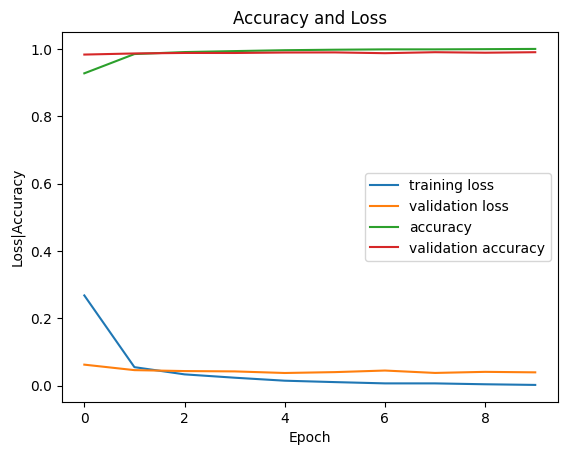

In [10]:
# 8. Vẽ đồ thị loss, accuracy của traning set và validation set
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy') # sử dụng từ khóa accuracy thay vì acc
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy') # sử dụng từ khóa val_accuracy thay vì val_acc
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [11]:
# 9. Đánh giá model với dữ liệu test set
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.030739637091755867, 0.9908000230789185]


Kết quả trả về `[0.035371359437704086, 0.9887999892234802]` trong trường hợp này là kết quả của việc đánh giá model trên tập dữ liệu test. Cụ thể:

- Phần tử đầu tiên (`0.035371359437704086`) là giá trị của hàm loss trên tập dữ liệu test. Đây là giá trị trung bình của loss function trên các mẫu dữ liệu trong tập test.
  
- Phần tử thứ hai (`0.9887999892234802`) là độ chính xác của model trên tập dữ liệu test, được tính dưới dạng tỷ lệ giữa số lượng dự đoán đúng và tổng số lượng mẫu trong tập test.

Kết quả này cho thấy model có độ chính xác khoảng 98.88% trên tập dữ liệu test, và giá trị của hàm loss trên tập test là khoảng 0.035. Đây là các thông số quan trọng để đánh giá hiệu suất của model trên dữ liệu mới.

Ta sẽ dùng kết quả đánh giá của mode với test set để làm kết quả cuối cùng của model. Tức model của chúng ta dữ đoán chữ số có độ chính xác 98.92% với MNIST dataset. Nghĩa là dự đoán khoảng 100 ảnh thì sai 1 ảnh.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[[1.7348609e-07 1.1688502e-08 3.4767316e-09 1.1376121e-10 1.6803079e-07
  1.7011374e-08 9.9999964e-01 1.5019889e-10 2.6428499e-09 2.9741168e-10]]
Giá trị dự đoán:  6


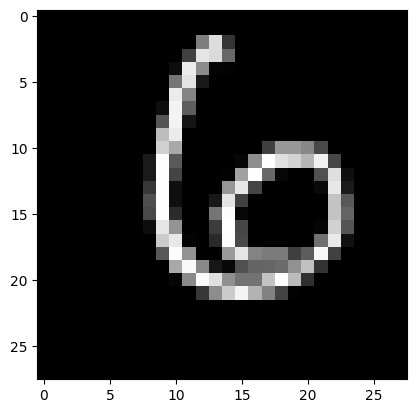

In [12]:
# 10. Dự đoán ảnh
plt.imshow(X_test[100].reshape(28,28), cmap='gray')
y_predict = model.predict(X_test[100].reshape(1,28,28,1))
print(y_predict)
print('Giá trị dự đoán: ', np.argmax(y_predict))

Trong ví dụ trên, bạn đã sử dụng mô hình để dự đoán một ảnh từ tập dữ liệu kiểm tra. Khi bạn gọi `model.predict(X_test[100].reshape(1,28,28,1))`, mô hình sẽ dự đoán lớp của ảnh được truyền vào. Kết quả trả về là một vector xác suất cho mỗi lớp có thể có. Trong trường hợp này, vector đó có 10 phần tử, mỗi phần tử thể hiện xác suất của mỗi lớp từ 0 đến 9.

Sau đó, bạn sử dụng `np.argmax(y_predict)` để tìm ra chỉ mục của phần tử có giá trị lớn nhất trong vector xác suất. Chỉ mục này tương ứng với lớp mà mô hình dự đoán cho ảnh đó. Trong trường hợp của bạn, chỉ mục đó là 6, nghĩa là mô hình dự đoán rằng ảnh đó chứa chữ số 6.

#### Lưu lại model và load ra lại để sử dụng khi cần (không cần phải chạy lại file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Giá trị dự đoán:  7
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Lớp được dự đoán cho mỗi mẫu trong batch đầu tiên:
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 5 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9]


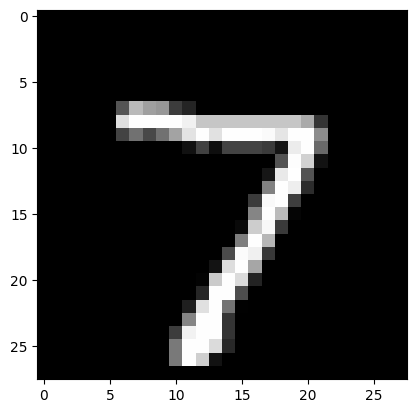

In [13]:
# Lưu model
model.save('my_model.h5')

from keras.models import load_model

# Load model
loaded_model = load_model('my_model.h5')

# 10. Dự đoán ảnh
plt.imshow(X_test[0].reshape(28,28), cmap='gray')

y_predict = loaded_model.predict(X_test[0].reshape(1,28,28,1))
print('Giá trị dự đoán: ', np.argmax(y_predict))

# Dự đoán cho một batch mẫu dữ liệu
batch_predictions = model.predict(X_test[:100])
# Lấy chỉ số của lớp có xác suất cao nhất cho mỗi mẫu
predicted_classes = np.argmax(batch_predictions, axis=1)

print('Lớp được dự đoán cho mỗi mẫu trong batch đầu tiên:')
print(predicted_classes)

### Với bài toán nhận diện chữ số từ 0 đến 9
#### Danh sách các tham số có thể thay đổi để tối ưu model 
- Thay đổi số lượng kernel : k (32) và kích thước kernel : w(3, 3) . model.add(Conv2D(32, (3, 3), activation='sigmoid', input_shape=(X_train.shape[1:])))
- Thay đổi hàm kích hoạt tại các lớp tích chập Conv2D : activation (sigmoid) bằng các hàm khác 
- Pooling : MaxPooling2D  thay bằng phương pháp khác ví dụ AveragePooling2D (trung bình) và thay đổi kích thước pooling 
- Số lượng node trong các lớp Fully Connected (128) có thể thay đổi thành một số nodes khác 
- Hàm loss và optimizer: Thử nghiệm với các hàm loss khác nhau như 'categorical_crossentropy', 'mean_squared_error' và các optimizer khác nhau như 'adam', 'sgd', 'rmsprop' để xem liệu cách lựa chọn này có ảnh hưởng đến hiệu suất của mô hình không.
- Batch_size: Thay đổi batch_size có thể ảnh hưởng đến tốc độ huấn luyện và độ chính xác của mô hình , có thể thay đổi trong tốc độ học và hiệu suất của mô hình.
- Epochs: Thay đổi số lượng epochs có thể giúp bạn xác định khi nào mô hình đã hội tụ và khi nào nó bắt đầu overfitting, có thể giảm số lượng epochs nếu thấy mô hình bắt đầu overfitting trên dữ liệu huấn luyện hoặc tăng số lượng epochs nếu mô hình vẫn chưa hội tụ.
- Metrics, bạn có thể đo lường hiệu suất của mô hình bằng các phương pháp khác nhau, không chỉ là accuracy. 
    + Accuracy: Tỷ lệ dự đoán chính xác trên tất cả các mẫu.
    + Precision: Tỷ lệ giữa số lượng dự đoán dương tính đúng và tổng số dự đoán dương tính.
    + Recall: Tỷ lệ giữa số lượng dự đoán dương tính đúng và tổng số mẫu thực sự là dương tính.
    + F1-score: Trung bình điều hòa giữa Precision và Recall.
    + ROC-AUC: Diện tích dưới đường cong ROC (Receiver Operating Characteristic), thường được sử dụng cho các bài toán phân loại nhị phân.
    + Mean Squared Error (MSE): Trung bình của bình phương của sự khác biệt giữa các giá trị dự đoán và giá trị thực tế.
    + Mean Absolute Error (MAE): Trung bình của giá trị tuyệt đối của sự khác biệt giữa các giá trị dự đoán và giá trị thực tế.
    + R-squared (R2): Phần trăm phương sai của biến phụ thuộc mà mô hình giải thích được.

#### Danh sách các tham số không nên thay đổi 
- Kích thước dữ liệu đầu vào , đây là các con số gần như cố định , D=1 hay D=3 phụ thuộc vào ảnh xám hay ảnh màu 
- Hàm loss của bài toán , ví dụ như đây là bài nhiều hơn 2 nhãn thì dùng categorical cross-entropy , không dùng sigmoid (2 nhãn)
- Thuật toán tối ưu : Adam , thường thì adam là thuật toán tốt nhất trong các thuật toán tối ưu , nên có thay đổi thì có thể accuracy cũng không thay đổi mấy
- Các lớp Dense cuối như 2 lớp cuối : Các hàm kích hoạt của nó thì sigmoid sau đó đến softmax là không nên thay đổi vì nó liên quan đến yêu cầu bài toán 
- Số node của lớp Dense cuối (10) phụ thuộc vào số nhãn cần nhận diện của bài toán 